In [1]:
%matplotlib inline
import os
import sys

from collections import OrderedDict
from copy import deepcopy
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sc

import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt

from pymc3 import Dirichlet, Poisson, Gamma
from pymc3 import math as pmmath
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from theano import shared
from theano.sandbox.rng_mrg import MRG_RandomStreams

# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64

plt.style.use("seaborn-darkgrid")

In [2]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds."""

    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name="w0")
        self.b0 = shared(0.01 * rng.randn(n_hidden), name="b0")
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics)).ravel(), name="w1")
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics)), name="b1")
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1 - self.p_corruption),
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, : (self.n_topics)]
        zs_rho = zs[:, (self.n_topics) :]
        return {"mu": zs_mean, "rho": zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [3]:
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=("headers", "footers", "quotes"))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words="english")

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.202s.
Extracting tf features for LDA...
done in 1.445s.


In [4]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print("Number of docs for training = {}".format(docs_tr.shape[0]))
print("Number of docs for test = {}".format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print(f"Number of tokens in training set = {n_tokens}")
print(
    "Sparsity = {}".format(len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1]))
)

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480280
Sparsity = 0.0253937


In [5]:
# def logp_lda_doc(beta, theta):
#     """Returns the log-likelihood function for given documents.

#     K : number of topics in the model
#     V : number of words (size of vocabulary)
#     D : number of documents (in a mini-batch)

#     Parameters
#     ----------
#     beta : tensor (K x V)
#         Word distributions.
#     theta : tensor (D x K)
#         Topic distributions for documents.
#     """

#     def ll_docs_f(docs):
#         dixs, vixs = docs.nonzero()
#         vfreqs = docs[dixs, vixs]
#         ll_docs = (
#             vfreqs * pmmath.logsumexp(tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
#         )

#         # Per-word log-likelihood times num of tokens in the whole dataset
#         return tt.sum(ll_docs) / (tt.sum(vfreqs) + 1e-9) * n_tokens

#     return ll_docs_f


def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """

    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        """
        \log p(d | theta, beta) = \sum_w \log p(w | theta, beta)
                                = \sum_w \log Poisson(w | theta @ beta) 
                                = \sum_w \log Poisson(w | \sum_k theta_k * beta_k)
                                = \sum_w \log Poisson(w | \sum_k \exp( \log theta_k + \log beta_k ))
                                = \sum_w - \sum_k \exp( \log theta_k + \log beta_k ) + w * \log \sum_k \exp( \log theta_k + \log beta_k ) - \log gamma(w + 1)
        """
        ll_docs = (
            (theta[dixs] + beta.T[vixs]).sum(1) + 
            vfreqs * pmmath.logsumexp(tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel() - \
            pm.distributions.special.gammaln(vfreqs + 1)
        )
        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs) + 1e-9) * n_tokens

    return ll_docs_f

/home/liutianc/miniconda3/lib/python3.7/site-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [81]:
n_topics = 20
minibatch_size = 128

doc_t_minibatch = pm.Minibatch(docs_te.toarray(), minibatch_size)
doc_t = shared(docs_te.toarray()[:minibatch_size])


e0 = c0 = 1.
f0 = .01
pn = .5

with pm.Model() as model:
    beta = Dirichlet(
        "beta",
        a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
        shape=(n_topics, n_words),
    )

    gamma0 = Gamma(
        "gamma0", 
        alpha=pm.floatX(e0 * np.ones((1, n_topics))),
        beta=pm.floatX(f0 * np.ones((1, n_topics))),
        shape=(minibatch_size, n_topics)
    )
    
    gamma = Gamma(
        "gamma",
        alpha=gamma0, 
        beta=1 / 0.001,
        shape=(minibatch_size, n_topics)
    )

    theta = Gamma(
        "theta",
        alpha=gamma,
        beta=pm.floatX((pn / (1. - pn)) * np.ones((minibatch_size, n_topics))),
#         beta=10.,
        shape=(minibatch_size, n_topics),
        total_size=n_samples_tr,
    )

    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist("doc", logp_lda_doc(beta, theta), observed=doc_t)

    step = pm.Metropolis()
    trace = pm.sample(1000, step)
    

/home/liutianc/miniconda3/lib/python3.7/site-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [gamma]
>Metropolis: [gamma0]
>Metropolis: [beta]
Sampling 4 chains, 0 divergences:   0%|          | 0/6000 [00:

In [71]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [72]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

In [73]:
η = .1
s = shared(η)


def reduce_rate(a, h, i):
    s.set_value(η / ((i / minibatch_size) + 1) ** 0.7)


with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    
inference.fit(
    10000,
    callbacks=[reduce_rate],
    obj_optimizer=pm.sgd(learning_rate=s),
    more_obj_params=encoder_params,
    total_grad_norm_constraint=200,
    more_replacements={doc_t: doc_t_minibatch},
)


Average Loss = 2.4587e+07: 100%|██████████| 10000/10000 [06:46<00:00, 24.62it/s]
Finished [100%]: Average Loss = 2.4544e+07


In [74]:
print(approx)


Approximation{MeanFieldGroup[None, 20] & MeanFieldGroup[22540]}


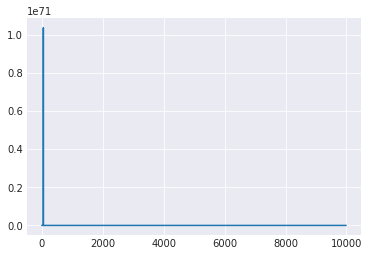

In [75]:
plt.plot(approx.hist[10:]);

In [76]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(
            ("Topic #%d: " % i)
            + " ".join([feature_names[j] for j in beta[i].argsort()[: -n_top_words - 1 : -1]])
        )

doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples["beta"].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: ax don like max b8f just know file people a86
Topic #1: ax b8f a86 max don just like 145 know does
Topic #2: don just people like know did does time think file
Topic #3: don just know people like does time good use file
Topic #4: don like just does people know edu new did good
Topic #5: just like don people ax does know good edu new
Topic #6: just don people like did does know edu good think
Topic #7: just don like edu does know people good make new
Topic #8: don ax people just like know did good file entry
Topic #9: just know people don like file good does ax make
Topic #10: ax 10 like new edu don just 45 people does
Topic #11: ax max don like a86 b8f just 10 know 1d9
Topic #12: people don does like know file just new entry said
Topic #13: ax max like don know just file b8f does good
Topic #14: don know like just people file does time good entry
Topic #15: don people know just like does good did said think
Topic #16: like file don just people new edu good know available
Topi

# LDA

In [8]:
η = 0.1
s = shared(η)


def reduce_rate(a, h, i):
    s.set_value(η / ((i / minibatch_size) + 1) ** 0.7)


with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(
    10000,
    callbacks=[reduce_rate],
    obj_optimizer=pm.sgd(learning_rate=s),
    more_obj_params=encoder_params,
    total_grad_norm_constraint=200,
    more_replacements={doc_t: doc_t_minibatch},
)


/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
  0%|          | 0/10000 [00:00<?, ?it/s]/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 4.858e+06: 100%|██████████| 10000/10000 [01:50<00:00, 90.75it/s] 
Finished [100%]: Average Loss = 4.8579e+06


In [9]:
print(approx)


Approximation{MeanFieldGroup[None, 9] & MeanFieldGroup[9990]}


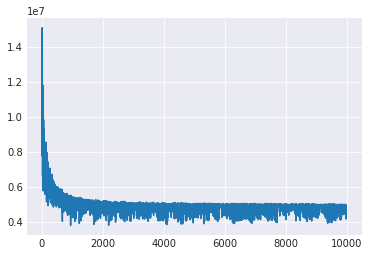

In [10]:
plt.plot(approx.hist[10:]);

In [11]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(
            ("Topic #%d: " % i)
            + " ".join([feature_names[j] for j in beta[i].argsort()[: -n_top_words - 1 : -1]])
        )


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples["beta"].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: ax people don just like know use time think does
Topic #1: does heard just like ram machine note know don installed
Topic #2: drive good scsi use israel just does ve like know
Topic #3: like cable parts know article does consider order break apple
Topic #4: price card don people does asking mac 00 original sale
Topic #5: people price does different use au pc just com card
Topic #6: memory mac good did players know don does crime non
Topic #7: just don like mark computer called designed example 70 built
Topic #8: got does like good 00 computer just car edu don
Topic #9: buy car just like drive don card good does mac
